# Illegal Mining
<hr>
# Notebook Summary

<hr>
# Algorithmic process  

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Retrieve the data from the datacube](#retrieve_data)
* [Obtain the clean mask](#obtain_clean_mask)
* [Filter out clouds, scan lines, and invalid data](#clean_mask)
* [Visualize Mean of NDVI Over Time](#ndvi)
* [Visualize Mean of WOFS Over Time](#wofs)
* [Visualize Mean of NDVI and WOFS Over Time](#ndvi_plus_wofs)
* [Visualize Mean of NDVI Across Time](#ndvi_across_time)

<hr>
# How It Works



## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_rgb import rgb
import numpy as np
import xarray as xr

from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Create an instance of the datacube and API.
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose Platform and Product</a>

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
8,LANDSAT_7,ls7_collections_sr_scene
67,LANDSAT_7,ls7_collections_sr_scene_lean
78,LANDSAT_7,ls7_collections_sr_scene_mini
19,LANDSAT_7,ls7_ledaps_amazon_river
20,LANDSAT_7,ls7_ledaps_bangladesh
35,LANDSAT_7,ls7_ledaps_bangladesh_bari
87,LANDSAT_7,ls7_ledaps_caqueta
21,LANDSAT_7,ls7_ledaps_colombia
22,LANDSAT_7,ls7_ledaps_ghana


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
9,LANDSAT_8,ls8_collections_sr_scene
69,LANDSAT_8,ls8_collections_sr_scene_lean
86,LANDSAT_8,ls8_lasrc_caqueta
73,LANDSAT_8,ls8_lasrc_honduras
32,LANDSAT_8,ls8_lasrc_lake_chad_full
33,LANDSAT_8,ls8_lasrc_meta_river
70,LANDSAT_8,ls8_lasrc_samoa
83,LANDSAT_8,ls8_lasrc_swiss_mini
77,LANDSAT_8,ls8_lasrc_switzerland


In [5]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
platform = 'LANDSAT_7'
product = 'ls7_ledaps_ghana'

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Get the Extents of the Cube</a>

In [6]:
# Get the extents of the cube
descriptor = api.get_query_metadata(platform=platform, product=product)

# Save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']
    
# Determine minimum and maximum longitudes that bound a common area among products
full_lon = (min_lon, max_lon)
full_lat = (min_lat, max_lat)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <a id="define_extents">Define the Extents of the Analysis</a>

**Specify an area and a point within it to analyze**

In [7]:
# Specify latitude and longitude bounds of an interesting area within the full extents.
# shown in the metadata report above (reduce area for faster processing times).
min_lat_small, max_lat_small = (8.8, 8.9) # Ghana (small)
# min_lat_small, max_lat_small = (8.4, 9.4) # Ghana (full)
# min_lat_small, max_lat_small = (0.6619, 0.6719) # Lake Baringo
min_lon_small, max_lon_small = (-1.8, -1.7)#(-1.8, -1.6) # Ghana (small)
# min_lon_small, max_lon_small =  (-1.6, -0.6) # Ghana (full)
# min_lon_small, max_lon_small = (36.1376, 36.1437) # Lake Baringo
# Display the subset of the region to be analyzed.
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

## <a id="retrieve_data">Retrieve the data from the datacube</a>

In [8]:
from datetime import datetime as dt
measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa']
start_date, end_date = min_date, max_date
# Query the Data Cube
dataset_in = dc.load(lat = lat_small,
                     lon = lon_small,
                     platform = platform,
                     time = (start_date, end_date),
                     product = product,
                     measurements = measurements)

In [9]:
print(dataset_in)

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372, time: 158)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T10:20:03 2000-02-02T10:20:02 ...
  * latitude   (latitude) float64 8.9 8.9 8.899 8.899 8.899 8.899 8.898 ...
  * longitude  (longitude) float64 -1.8 -1.8 -1.8 -1.799 -1.799 -1.799 ...
Data variables:
    red        (time, latitude, longitude) int16 1458 1517 1477 1595 1712 ...
    green      (time, latitude, longitude) int16 1297 1341 1363 1450 1494 ...
    blue       (time, latitude, longitude) int16 1127 1088 1187 1208 1287 ...
    swir1      (time, latitude, longitude) int16 2270 2321 2449 2629 2758 ...
    swir2      (time, latitude, longitude) int16 1428 1536 1671 1888 1997 ...
    nir        (time, latitude, longitude) int16 2062 2062 2105 2191 2234 ...
    pixel_qa   (time, latitude, longitude) int32 66 66 66 66 66 66 66 66 66 ...
Attributes:
    crs:      EPSG:4326


## <a id="obtain_clean_mask">Obtain the clean masks</a>

**For more information on masking, please refer to Masking_Notebook.**

In [10]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Get the clean mask for the LANDSAT satellite platform
clean_mask = landsat_qa_clean_mask(dataset_in, platform)

## <a id="clean_mask">Filter out clouds, scan lines, and invalid data</a>

In [11]:
# Remove clouds and Landsat 7 scan lines.
cleaned_dataset = dataset_in.where(clean_mask)
# Remove data that is ouside the accepted range of LANDSAT 7 and 8.
cleaned_dataset = landsat_clean_mask_invalid(cleaned_dataset)

## <a id='ndvi'>Visualize Mean of NDVI Over Time</a>

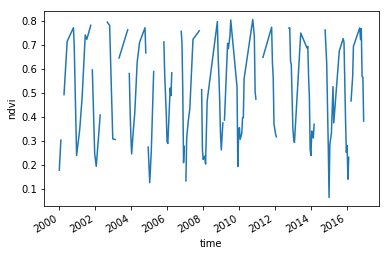

In [12]:
ndvi_arr = NDVI(cleaned_dataset)
ndvi_arr_mean_over_time = ndvi_arr.mean(dim=['latitude','longitude'])
ndvi_arr_mean_over_time.plot()
plt.xlabel('time')
plt.ylabel('ndvi')
plt.show()

## <a id="wofs">Visualize Mean of WOFS Over Time</a>

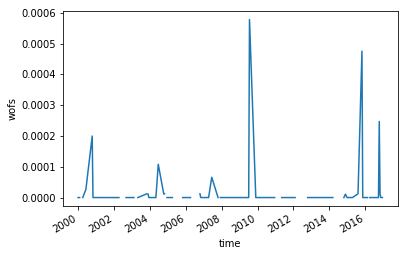

In [13]:
wofs_arr = wofs_classify(cleaned_dataset, clean_mask).wofs
wofs_arr = wofs_arr.where(wofs_arr!=-9999)
wofs_arr_mean_over_time = wofs_arr.mean(dim=['latitude','longitude'])
wofs_arr_mean_over_time.plot()
plt.xlabel('time')
plt.ylabel('wofs')
plt.show()

## <a id="ndvi_plus_wofs">Visualize Mean of NDVI and WOFS Over Time</a>

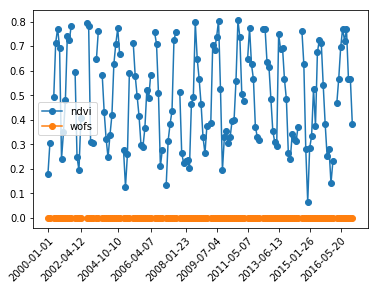

In [14]:
from utils.data_cube_utilities.plotter_utils import xarray_plot_data_vars_over_time

ndvi_wofs_combined = xr.Dataset({'ndvi':ndvi_arr, 'wofs':wofs_arr})
xarray_plot_data_vars_over_time(ndvi_wofs_combined.mean(dim=['latitude', 'longitude']))

## <a id="ndvi_across_time">Visualize Mean of NDVI Across Time</a>

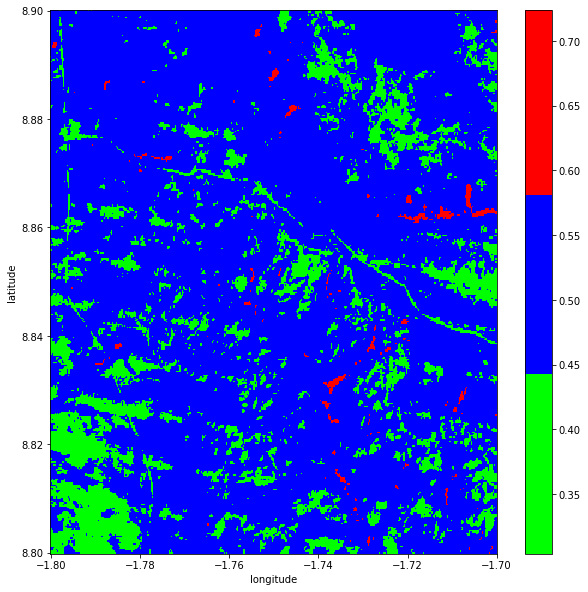

In [15]:
from utils.data_cube_utilities.plotter_utils import create_discrete_color_map
th = [0.33, 0.5] # Color thresholds
cmap = create_discrete_color_map(th, [(0, 1, 0), 'blue', 'red'], 0.75) # green (vibrant), blue, and red.
plt.figure(figsize=(10,10))
ndvi_arr_mean_across_time = ndvi_arr.mean(dim='time')
ndvi_arr_mean_across_time.plot(cmap=cmap)